# REINFORCE for CartPole-v1

In [1]:
# Import required libraries

import argparse
import gym
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import numpy as np
from itertools import count
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

## Environment Parameters

In [2]:
# Set constants for training
seed = 974
log_interval = 10
gamma = 0.99

env = gym.make('CartPole-v1')
env.reset(seed=seed)
torch.manual_seed(seed)

SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

num_i_nodes = 4
num_h_nodes = 64
num_o_nodes = 2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


## Neural Networks for Policy and Value Function

### Policy Neural Network

In [3]:
class Policy(nn.Module):
    """
    Implements the policy network for REINFORCE.
    """
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(num_i_nodes, num_h_nodes)
        # self.dropout = nn.Dropout(0.5)
        self.action_head = nn.Linear(num_h_nodes, num_o_nodes)  # Output layer for actions

        # Initialize the weights
        self.init_weights()

        # Action and reward buffer
        self.saved_actions = []
        self.rewards = []

    def init_weights(self):
        # Initialize the weights of the linear layers
        nn.init.kaiming_normal_(self.affine1.weight, nonlinearity='relu')
        # nn.init.xavier_uniform_(self.affine1.weight)
        nn.init.constant_(self.affine1.bias, 0)
        nn.init.kaiming_normal_(self.action_head.weight, nonlinearity='relu')
        # nn.init.xavier_uniform_(self.action_head.weight)
        nn.init.constant_(self.action_head.bias, 0)

    def forward(self, x):
        """
        Forward pass of the policy network.
        """
        x = F.relu(self.affine1(x))
        # x = self.dropout(x) # Apply dropout
        action_scores = F.softmax(self.action_head(x), dim=-1)  # Actor: Action probabilities
        return action_scores

### Policy Neural Network

In [4]:
model = Policy()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
eps = np.finfo(np.float32).eps.item()
all_frames = []

## Training Functions

### Action

In [5]:
def select_action(state):
    """
    Selects an action from the policy network given the current state.
    """
    state = torch.from_numpy(state).float()
    probs = model(state)

    # Create a categorical distribution over the list of probabilities of actions
    m = Categorical(probs)

    # Sample an action using the distribution
    action = m.sample()

    # Save the log probability and state value in the model's saved_actions
    model.saved_actions.append(m.log_prob(action))

    # Return the action to take (left or right)
    return action.item(), m.log_prob(action)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Returns

In [6]:
def calculate_returns(rewards, discount_factor, normalize = False):

    returns = []
    R = 0

    for r in reversed(rewards):
        R = r + R * discount_factor
        returns.insert(0, R)

    # returns = torch.tensor(returns)

    if normalize:
        returns = (returns - returns.mean()) / returns.std()

    return returns

### Completion and Updation

In [7]:
def finish_episode():
    policy_loss = []
    returns = calculate_returns(model.rewards, gamma)
    for log_prob, G in zip(model.saved_actions, returns):
        policy_loss.append(-log_prob * G)  # Compute policy loss only

    optimizer.zero_grad()
    loss = torch.stack(policy_loss).sum()
    loss.backward()
    optimizer.step()

    del model.rewards[:]
    del model.saved_actions[:]


### Training

In [8]:
def train(episodes):
    running_reward = 10  # Initialize running reward

    # Keep track of the rewards for plotting
    reward_history = []

    # Run infinitely many episodes
    for episode in range(episodes):

        # Reset environment and episode reward
        state = env.reset()
        ep_reward = 0

        # For each episode, only run 9999 steps to avoid infinite loop
        for t in range(1, 10000):

            # Select action from policy
            action, log_prob = select_action(state)

            # Take the action
            state, reward, done, _ = env.step(action)

            # Save rewards for this episode
            model.rewards.append(reward)
            ep_reward += reward

            if done:
                break

        # Update cumulative reward
        running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward

        # Store the reward
        reward_history.append(running_reward)

        # Perform policy update
        finish_episode()

        # Log results
        if episode % log_interval == 0:
            print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}'.format(
                episode, ep_reward, running_reward))

        # Check if the problem is solved
        if running_reward > env.spec.reward_threshold:
            print("Solved! Running reward is now {} and the last episode ({}) runs to {} time steps!".format(running_reward, episode, t))
            break

    return reward_history

## Commence Training

In [9]:
reward_history = train(2000)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0	Last reward: 12.00	Average reward: 10.10
Episode 10	Last reward: 39.00	Average reward: 19.10
Episode 20	Last reward: 56.00	Average reward: 33.14
Episode 30	Last reward: 80.00	Average reward: 49.15
Episode 40	Last reward: 65.00	Average reward: 58.26
Episode 50	Last reward: 120.00	Average reward: 80.02
Episode 60	Last reward: 106.00	Average reward: 90.52
Episode 70	Last reward: 239.00	Average reward: 143.33
Episode 80	Last reward: 118.00	Average reward: 161.13
Episode 90	Last reward: 81.00	Average reward: 138.92
Episode 100	Last reward: 254.00	Average reward: 166.91
Episode 110	Last reward: 140.00	Average reward: 236.69
Episode 120	Last reward: 45.00	Average reward: 174.90
Episode 130	Last reward: 36.00	Average reward: 125.79
Episode 140	Last reward: 61.00	Average reward: 97.80
Episode 150	Last reward: 41.00	Average reward: 80.26
Episode 160	Last reward: 58.00	Average reward: 72.26
Episode 170	Last reward: 40.00	Average reward: 67.40
Episode 180	Last reward: 50.00	Average rewar

## Reward History Plot During Training

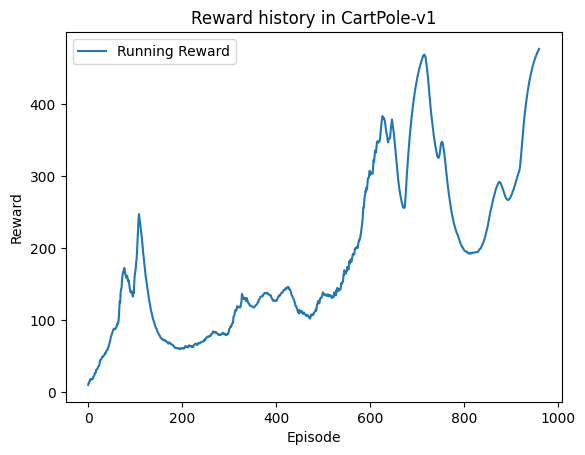

In [10]:
# Plot the reward history

plt.plot(reward_history)
plt.title('Reward history in CartPole-v1')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(['Running Reward'])
plt.show()

## Save Model

In [11]:
torch.save(model, 'REINFORCE_CartPole_v1.pth')

## Evaluation of the Model

In [12]:
# Evaluate the policy using total regret

def calculate_total_regret(episodes):
    """
    Evaluate the policy using total regret.
    """
    total_regret = 0

    # Use reward history to calculate total regret
    for reward in reward_history:
        total_regret += env.spec.reward_threshold - reward

    return total_regret

## Hyperparameter Tuning

In [ ]:
# Hyperparameter tuning

# Set the hyperparameters
hyperparameters = {
    'lr': [1e-2, 1e-3, 1e-4],
    'num_h_nodes': [32, 64, 128]
}

env.reset(seed=seed)
torch.manual_seed(seed)
log_interval = 10
episodes = 2000
best_total_regret = float('inf')
best_hyperparameters = {}
best_episodes = 2000
regret_storage = []
reward_history_storage = np.zeros((len(hyperparameters['lr']), len(hyperparameters['num_h_nodes']), episodes))

# Loop through the hyperparameters
for lr in hyperparameters['lr']:
    for num_h_nodes in hyperparameters['num_h_nodes']:

        # Set the hyperparameters
        model = Policy()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Train the model
        reward_history = train(episodes)
        len_episodes = len(reward_history)
        reward_history += [env.spec.reward_threshold] * (episodes - len(reward_history))
        reward_history_storage[hyperparameters['lr'].index(lr), hyperparameters['num_h_nodes'].index(num_h_nodes), :] = reward_history

        # Calculate the total regret
        total_regret = calculate_total_regret(episodes)

        # Store the total regret
        regret_storage.append([lr, num_h_nodes, total_regret])

        # Check if this is the best total regret
        if total_regret < best_total_regret:
            best_total_regret = total_regret
            best_hyperparameters = {'lr': lr, 'num_h_nodes': num_h_nodes}
            best_episodes = len_episodes

In [17]:
# Print the best hyperparameters
print('Best hyperparameters:', best_hyperparameters)
print('Best total regret:', best_total_regret)

Best hyperparameters: {'lr': 0.01, 'num_h_nodes': 64}
Best total regret: 272693.2173361074


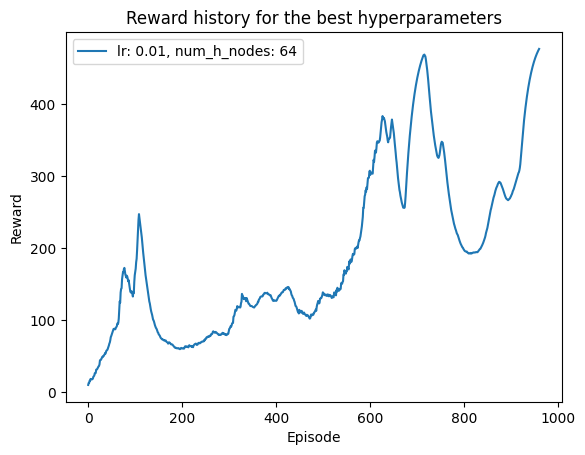

In [18]:
# Plot the reward history for the best hyperparameters

plt.plot(reward_history_storage[hyperparameters['lr'].index(best_hyperparameters['lr']), hyperparameters['num_h_nodes'].index(best_hyperparameters['num_h_nodes']), :best_episodes])
plt.title('Reward history for the best hyperparameters')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(['lr: {}, num_h_nodes: {}'.format(best_hyperparameters['lr'], best_hyperparameters['num_h_nodes'])])
plt.show()